# Preprocessing data for fitting the SVM

#### Create boat location mask from Miami_boats.png

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
import time

# Function to apply Gaussian filter
def apply_gaussian_filter(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Function to load, resize and preprocess images
def load_and_preprocess_image(image_path, scale_percent, filter_type=False):
    image = cv2.imread(image_path)
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height))
    
    if filter_type:
        resized_image = apply_gaussian_filter(resized_image)
        print("Filtered with Gaussian")
    
    return resized_image

#### Rescaling original image and it's water image

In [19]:
# Load the training images
original_image_path = "../satellite-images/Miami.jpg"
boat_mask_image_path = "../satellite-images/Miami_boats.png"


filter_true = False  # gaussian filter
scale_percent = 3
original_image_low_res = load_and_preprocess_image(original_image_path, scale_percent, filter_true)
boat_mask_image = cv2.imread(boat_mask_image_path)
boat_mask_image_low_res = cv2.resize(boat_mask_image, (original_image_low_res.shape[1], original_image_low_res.shape[0]))

Unique values in the boat mask image after thresholding: [  0 255]


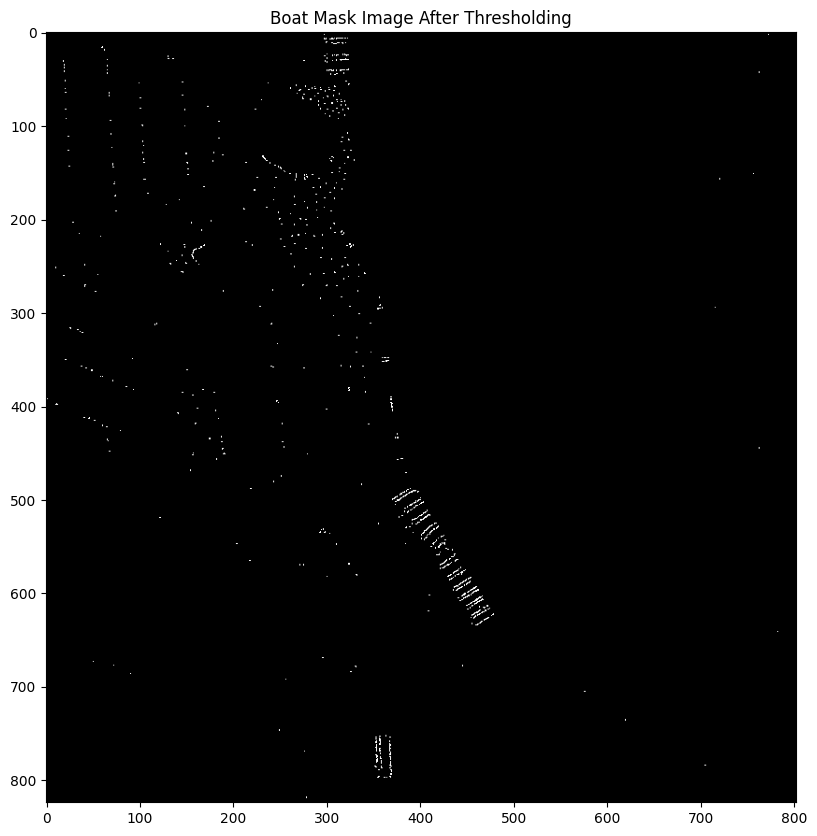

In [20]:
# Detecting red and purple pixels
lower_red = np.array([0, 0, 100])
upper_red = np.array([100, 100, 255])
red_mask = cv2.inRange(boat_mask_image_low_res, lower_red, upper_red)

lower_purple = np.array([100, 0, 100])
upper_purple = np.array([255, 100, 255])
purple_mask = cv2.inRange(boat_mask_image_low_res, lower_purple, upper_purple)

# Combine both masks
boat_mask_binary = cv2.bitwise_or(red_mask, purple_mask)

unique_values = np.unique(boat_mask_binary)
print(f"Unique values in the boat mask image after thresholding: {unique_values}")

# Display the boat mask image
plt.figure(figsize=(10, 10))
plt.title('Boat Mask Image After Thresholding')
plt.imshow(boat_mask_binary, cmap='gray')
plt.show()

In [21]:
labels = (boat_mask_binary == 255).astype(np.uint8)

unique_labels = np.unique(labels)
print(f"Unique labels in the processed boat mask: {unique_labels}")

Unique labels in the processed boat mask: [0 1]


In [22]:
if len(unique_labels) < 2:
    print("The boat mask image does not contain both boat and non-boat labels.")
else:
    flat_image = original_image_low_res.reshape((-1, 3))
    flat_labels = labels.flatten()

    print(f"Number of samples in flat_image: {flat_image.shape[0]}")
    print(f"Number of samples in flat_labels: {flat_labels.shape[0]}")

Number of samples in flat_image: 661672
Number of samples in flat_labels: 661672


In [23]:
start_time = time.time()
svm = SVC(kernel='rbf')  # Using RBF kernel
svm.fit(flat_image, flat_labels)
end_time = time.time()
print(f"Time spent fitting: {end_time - start_time}")

Time spent fitting: 401.324688911438


In [25]:
svm_model_path = '../svm-all-boats-results/svm-model-all-boats-3percent.pkl'
joblib.dump(svm, svm_model_path)
print(f"SVM model saved to {svm_model_path}")

SVM model saved to ../svm-all-boats-results/svm-model-all-boats-3percent.pkl


In [26]:
# Predict the same image to calculate accuracy
start_time = time.time()
predicted_labels = svm.predict(flat_image)
predicted_mask = predicted_labels.reshape(original_image_low_res.shape[:2])
end_time = time.time()
print(f"Time spent predicting: {end_time - start_time}")

Time spent predicting: 86.79649090766907


In [27]:
# Calculate the accuracy
accuracy = accuracy_score(flat_labels, predicted_labels)

Accuracy of SVM mask compared to given boat mask: 99.74%


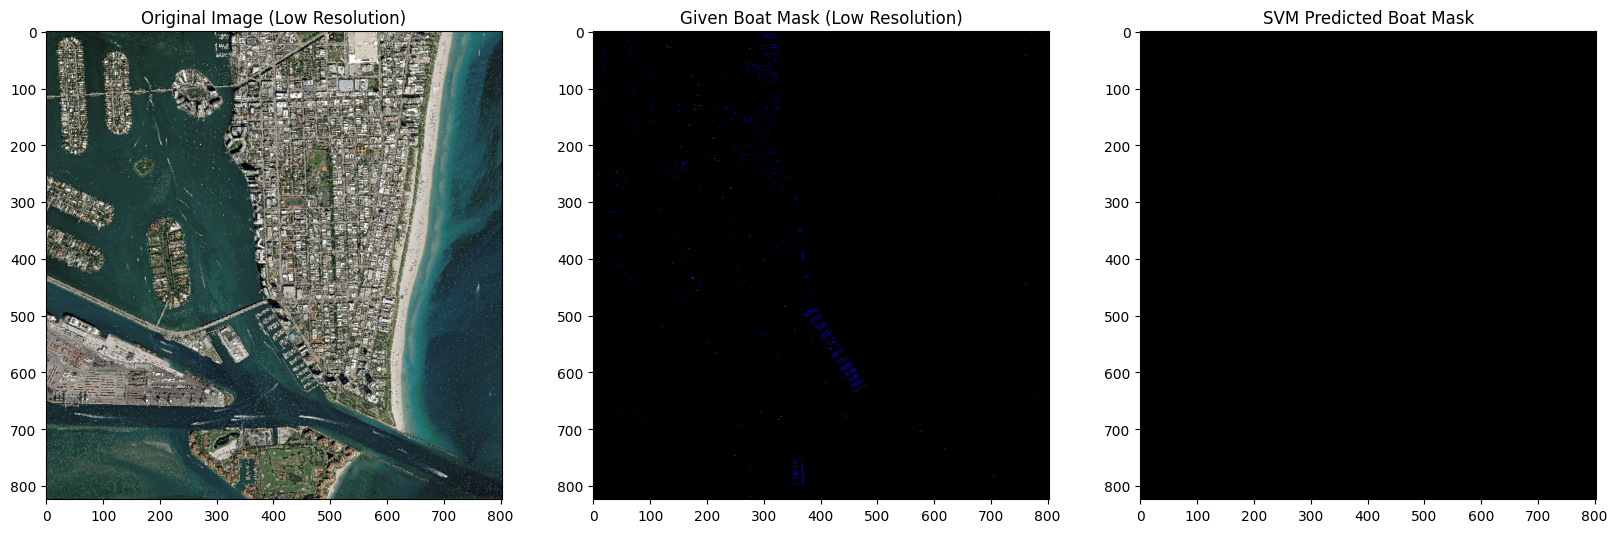

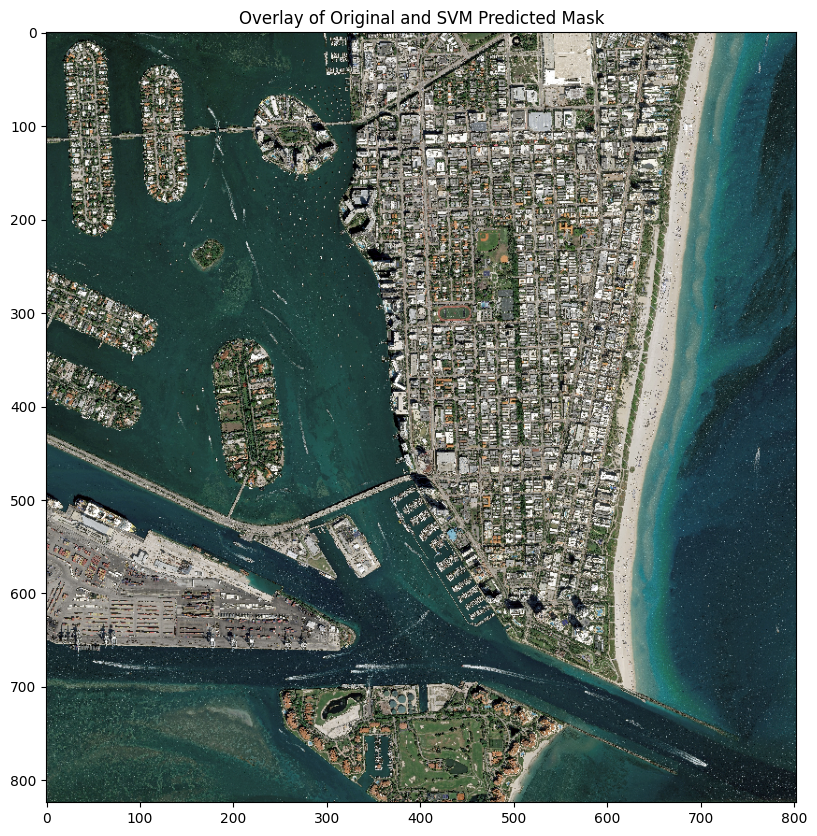

In [28]:
# Display the images
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title('Original Image (Low Resolution)')
plt.imshow(cv2.cvtColor(original_image_low_res, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title('Given Boat Mask (Low Resolution)')
plt.imshow(boat_mask_image_low_res, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('SVM Predicted Boat Mask')
plt.imshow(predicted_mask, cmap='gray')

# Overlay images to compare
overlay = original_image_low_res.copy()
overlay[predicted_mask == 1] = [0, 255, 0]  # Highlight predicted boat areas in green

plt.figure(figsize=(10, 10))
plt.title('Overlay of Original and SVM Predicted Mask')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))

# Print the accuracy
print(f"Accuracy of SVM mask compared to given boat mask: {accuracy * 100:.2f}%")

plt.show()